In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('loan_data_part_8.csv')

# Display the first few rows of the dataset
print(data.head())

          id  loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  \
0  108514182       7200         7200           7200.0    36     11.99   
1  137750669       7200         7200           7200.0    36      8.46   
2   56050637      12000        12000          12000.0    36      8.18   
3  138971960       3600         3600           3600.0    36     14.47   
4   61378160      10200        10200          10200.0    60     19.19   

   installment grade sub_grade  emp_length  ... num_tl_op_past_12m  \
0       239.11     B        B5           1  ...                  3   
1       227.16     A        A5           8  ...                  1   
2       377.04     B        B1          10  ...                  1   
3       123.87     C        C2           2  ...                  2   
4       265.67     E        E3           4  ...                  8   

   pct_tl_nvr_dlq percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  \
0            92.0             80.0                     0          0  

In [90]:
if 'fico_range_high' in data.columns and 'fico_range_low' in data.columns:
    data['fico_range_avg'] = (data['fico_range_high'] + data['fico_range_low']) / 2
else:
    raise ValueError("The columns 'fico_range_high' or 'fico_range_low' are not found in the dataset.")

# Checking the first few rows to confirm the new column
data[['fico_range_high', 'fico_range_low', 'fico_range_avg']].head()

,fico_range_high,fico_range_low,fico_range_avg
0,669,665,667.0
1,709,705,707.0
2,699,695,697.0
3,669,665,667.0
4,679,675,677.0


In [91]:
# Check for missing values
print(data.isnull().sum())

# Drop rows with missing values (if any)
data = data.dropna()

# Select relevant features (you can adjust this based on stepwise regression results)
features = ['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'revol_bal', 'revol_util', 'total_acc','total_rec_int','tot_coll_amt','tot_cur_bal','acc_open_past_24mths','tot_hi_cred_lim']
X = data[features]
y = data['fico_range_avg']

# Convert categorical variables to dummy variables (if any)
X = pd.get_dummies(X, drop_first=True)

id                            0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
                             ..
total_bal_ex_mort             0
total_bc_limit                0
total_il_high_credit_limit    0
hardship_flag                 0
fico_range_avg                0
Length: 78, dtype: int64


In [92]:
import statsmodels.api as sm

# Add a constant to the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

# Based on the p-values, select the significant features
significant_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'revol_util']
X = data[significant_features]

                            OLS Regression Results                            
Dep. Variable:         fico_range_avg   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     7159.
Date:                Sat, 22 Feb 2025   Prob (F-statistic):               0.00
Time:                        02:26:22   Log-Likelihood:            -5.0926e+05
No. Observations:              110855   AIC:                         1.019e+06
Df Residuals:                  110840   BIC:                         1.019e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  744.4279 

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Initialize the Decision Tree Regressor
reg_tree = DecisionTreeRegressor(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(reg_tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = (-cv_scores) ** 0.5

print(f"Cross-Validation RMSE: {cv_rmse_scores.mean()}")

# Fit the model on the training data
reg_tree.fit(X_train, y_train)

# Prune the tree by setting a maximum depth
pruned_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
pruned_tree.fit(X_train, y_train)

# Evaluate the pruned tree on the training data
y_train_pred = pruned_tree.predict(X_train)
train_rmse = math.sqrt(mean_squared_error(y_train, y_train_pred))
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Evaluate the pruned tree on the testing data
y_test_pred = pruned_tree.predict(X_test)
test_rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print training performance metrics
print("\nTraining Performance:")
print(f"RMSE: {train_rmse:.4f}")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")
print(f"MAE: {train_mae:.4f}")

# Print testing performance metrics
print("\nTesting Performance:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")
print(f"MAE: {test_mae:.4f}")

Cross-Validation RMSE: 34.166778634694666

Training Performance:
RMSE: 24.9607
MSE: 623.0385
R²: 0.4301
MAE: 19.5271

Testing Performance:
RMSE: 24.8829
MSE: 619.1597
R²: 0.4254
MAE: 19.5371


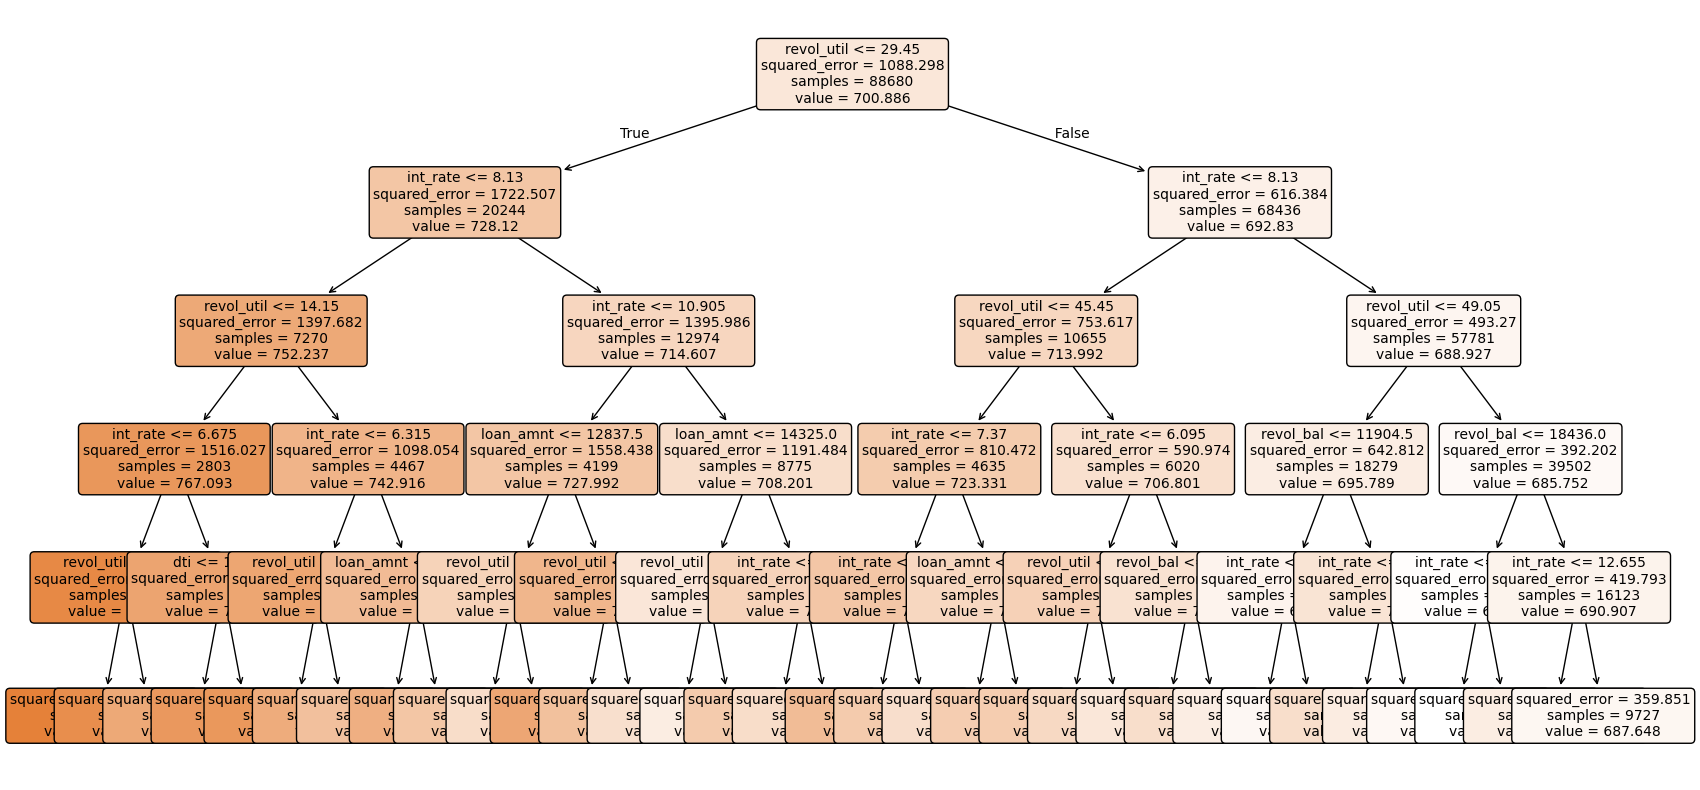

In [41]:
plt.figure(figsize=(20,10))
plot_tree(pruned_tree, filled=True, feature_names=X.columns, rounded=True, fontsize=10)
plt.show()